# Imports and Setup

In [1]:
# Standard imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..')))

# Set random seed for reproducibility
np.random.seed(42)

# Create necessary directories
os.makedirs('../models/regression', exist_ok=True)
os.makedirs('../reports', exist_ok=True)
os.makedirs('../reports/figures', exist_ok=True)

# Data Loading

In [2]:
from src.data_preprocessing import load_data, prepare_data

# Load data
print("Loading data...")
df = load_data('../data/processed/insurance_cleaned.csv')

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Separate features and targets
X = df.drop(['TotalClaims', 'has_claim'], axis=1)
y_reg = df['TotalClaims']
y_clf = df['has_claim']

print("\nData loaded successfully!")
print(f"Features shape: {X.shape}")
print(f"Regression target shape: {y_reg.shape}")
print(f"Classification target shape: {y_clf.shape}")

Loading data...
Loaded data with shape: (1000098, 14)

Missing values per column:
UnderwrittenCoverID         0
PolicyID                    0
transaction_date            0
TotalPremium                0
TotalClaims                 0
has_claim                   0
loss_ratio             381634
margin                      0
Province                    0
PostalCode                  0
Gender                   9536
VehicleType               552
make                      552
Model                     552
dtype: int64

Data loaded successfully!
Features shape: (1000098, 12)
Regression target shape: (1000098,)
Classification target shape: (1000098,)


# Data Preparation

In [3]:
# Prepare data with train/test split
print("Preparing data...")
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test, feature_names = prepare_data(
    X, y_reg, y_clf, test_size=0.2, random_state=42
)

# Display shapes
print("\nTraining set shapes:")
print(f"X_train: {X_train.shape}, y_reg_train: {y_reg_train.shape}, y_clf_train: {y_clf_train.shape}")
print("\nTest set shapes:")
print(f"X_test: {X_test.shape}, y_reg_test: {y_reg_test.shape}, y_clf_test: {y_clf_test.shape}")

# Check for any remaining non-numeric values
print("\nData types in X_train:")
print(X_train.dtypes.value_counts())

Preparing data...
Processed 1 date columns: ['transaction_date']
Numeric columns: 7
Categorical columns: 5
Processed date columns as numeric: ['transaction_date']

Training set shapes:
X_train: (800078, 471), y_reg_train: (800078,), y_clf_train: (800078,)

Test set shapes:
X_test: (200020, 471), y_reg_test: (200020,), y_clf_test: (200020,)

Data types in X_train:
float64    471
Name: count, dtype: int64


#  Data Sampling (Optional - for faster training)

In [4]:
# Take a sample of the training data for faster experimentation
sample_frac = 0.3  # Use 30% of the data
if len(X_train) > 100000:
    sample_size = int(len(X_train) * sample_frac)
    sample_idx = np.random.choice(len(X_train), size=sample_size, replace=False)
    
    X_train_sample = X_train.iloc[sample_idx].copy()
    y_reg_train_sample = y_reg_train.iloc[sample_idx].copy()
    y_clf_train_sample = y_clf_train.iloc[sample_idx].copy()
else:
    X_train_sample = X_train
    y_reg_train_sample = y_reg_train
    y_clf_train_sample = y_clf_train

print(f"Using {len(X_train_sample)} samples for training ({(len(X_train_sample)/len(X_train)*100):.1f}% of data)")

Using 240023 samples for training (30.0% of data)


# Model Training

In [7]:
from src.modeling import ModelTrainer
from sklearn.model_selection import train_test_split

# Initialize model trainer
print("Initializing ModelTrainer...")
reg_trainer = ModelTrainer(model_type='regression')

# Split training data into train and validation sets (80-20 split)
X_train_final, X_val, y_reg_train_final, y_reg_val = train_test_split(
    X_train_sample, 
    y_reg_train_sample,
    test_size=0.2,
    random_state=42
)

# Define model parameters
model_params = {
    'random_forest': {
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 5,
        'n_jobs': -1,
        'random_state': 42
    },
    'xgboost': {
        'n_estimators': 200,
        'max_depth': 5,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'tree_method': 'hist',
        'random_state': 42,
        'eval_metric': 'rmse',
        # These will be used in the fit() method
        'fit_params': {
            'eval_set': [(X_val, y_reg_val)],
            'early_stopping_rounds': 10,
            'verbose': 10
        }
    }
}

# Train models
print("\nTraining models...")
try:
    reg_trainer.train_models(
        X_train_final,  # Use the training split
        y_reg_train_final,  # Use the training target
        **model_params
    )
    print("Model training completed successfully!")
    
    # Store the validation set in the trainer for later use
    reg_trainer.X_val = X_val
    reg_trainer.y_reg_val = y_reg_val
    
except Exception as e:
    print(f"Error during model training: {str(e)}")
    raise

Initializing ModelTrainer...

Training models...

Training Linear Regression...
✓ Linear Regression trained

Training Random Forest...
✓ Random Forest trained

Training XGBoost...


c:\Users\bethy\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:52:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "fit_params" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✓ XGBoost trained
Model training completed successfully!


# Model Evaluation

Evaluating models...

Model Performance Metrics:


,RMSE,R-squared,MSE
Linear Regression,0.000,1.000,0.000
Random Forest,373.986,0.977,139865.177
XGBoost,1903.795,0.414,3624434.992


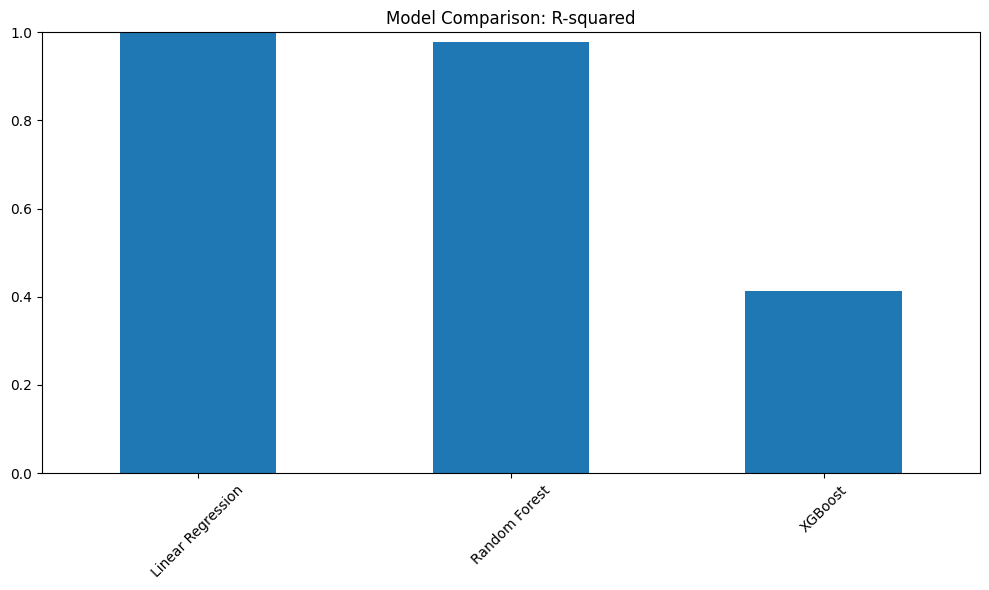

In [8]:
# Evaluate models
print("Evaluating models...")
try:
    metrics = reg_trainer.evaluate_models(X_test, y_reg_test)
    print("\nModel Performance Metrics:")
    display(metrics)
    
    # Plot performance
    plt.figure(figsize=(10, 6))
    metrics['R-squared'].plot(kind='bar')
    plt.title('Model Comparison: R-squared')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('../reports/figures/model_r2_comparison.png')
    plt.show()
    
except Exception as e:
    print(f"Error during model evaluation: {str(e)}")

# Feature Importance

Calculating feature importances...


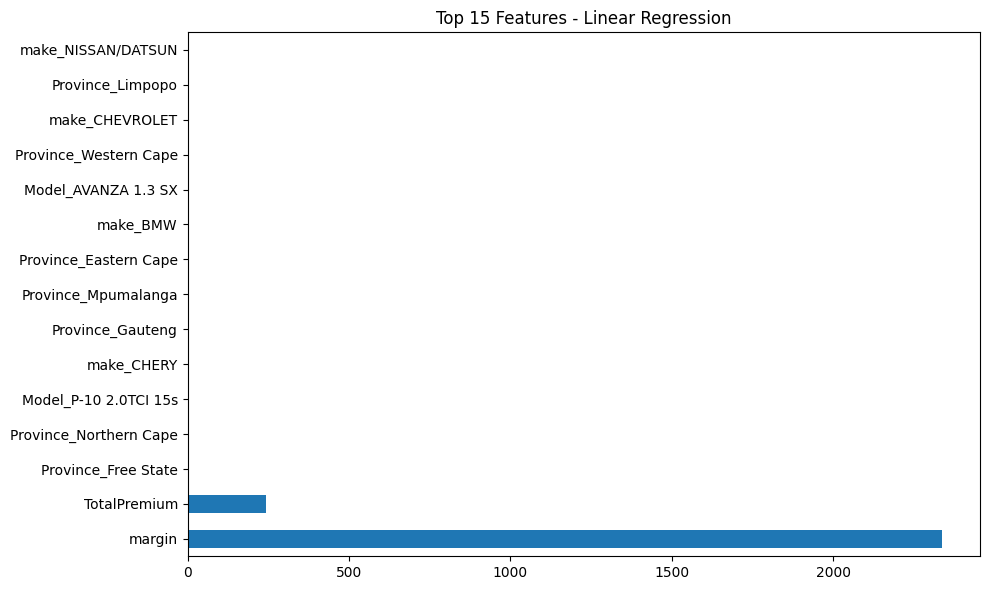

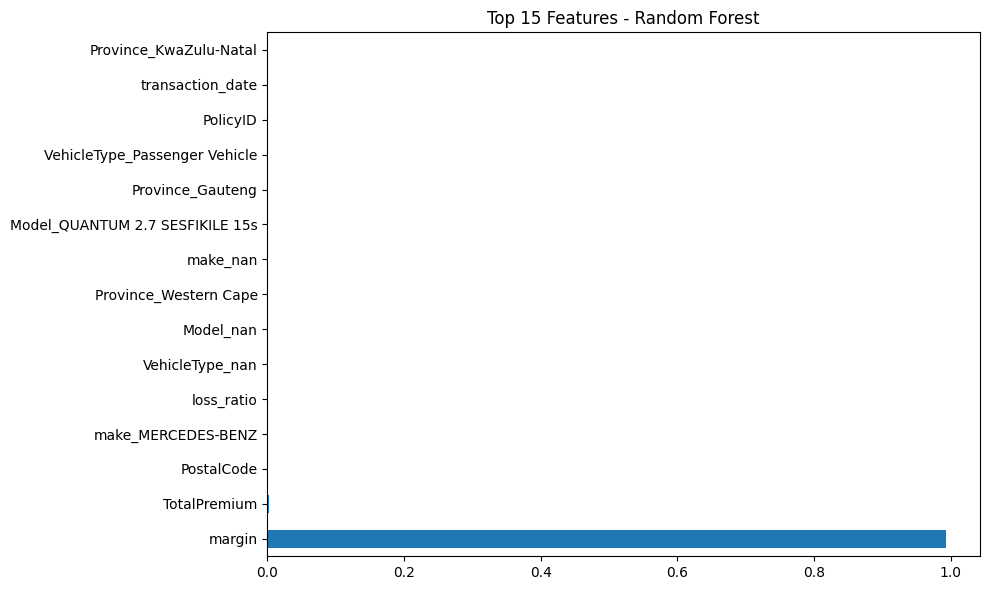

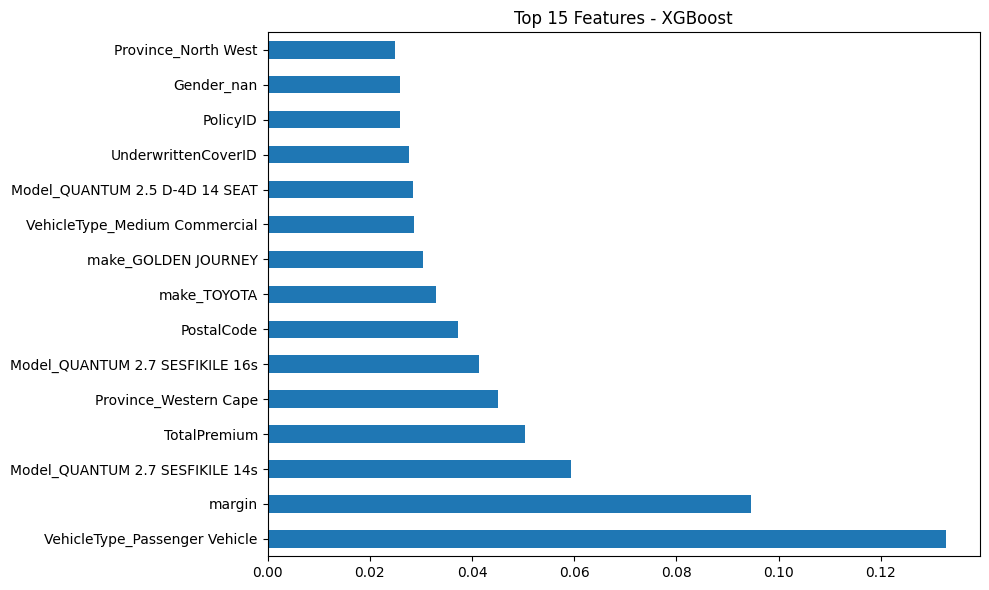


Saved Linear Regression feature importances to CSV

Saved Random Forest feature importances to CSV

Saved XGBoost feature importances to CSV


In [9]:
# Get and plot feature importances
print("Calculating feature importances...")
try:
    importances = reg_trainer.get_feature_importances(
        feature_names=feature_names,
        n_features=15  # Show top 15 features
    )
    
    # Save feature importances
    for model_name, importance_df in importances.items():
        if isinstance(importance_df, pd.Series):
            importance_df.to_csv(f'../reports/{model_name.lower().replace(" ", "_")}_feature_importances.csv')
            print(f"\nSaved {model_name} feature importances to CSV")
            
except Exception as e:
    print(f"Error calculating feature importances: {str(e)}")

# Save Models and Results

In [12]:
# Save trained models
print("Saving models...")
try:
    reg_trainer.save_models('../models/regression')
    
    # Save metrics
    metrics.to_csv('../reports/regression_metrics.csv')
    print("\nModels and metrics saved successfully!")
    
except Exception as e:
    print(f"Error saving models: {str(e)}")

Saving models...
✓ Saved Linear Regression to ../models/regression\linear_regression.joblib
✓ Saved Random Forest to ../models/regression\random_forest.joblib
✓ Saved XGBoost to ../models/regression\xgboost.joblib

Models and metrics saved successfully!


# SHAP explanation


Starting optimized SHAP analysis...
Analyzing Linear Regression on 500 samples...
Using LinearExplainer for faster computation...


C:\Users\bethy\AppData\Local\Temp\ipykernel_26672\1604692094.py:49: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)


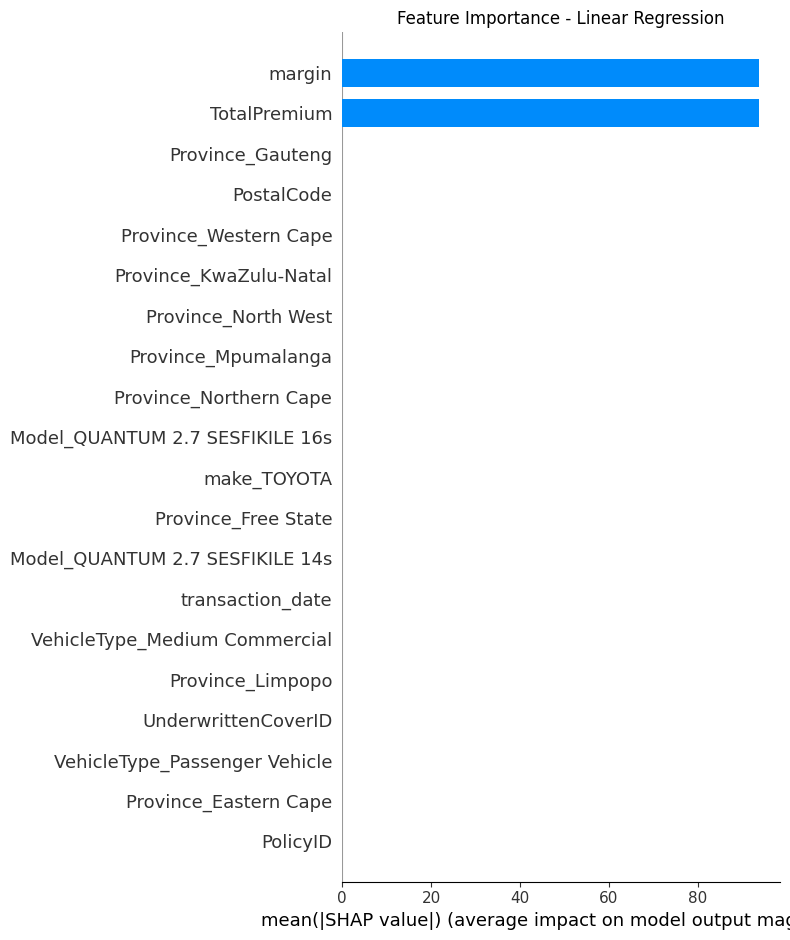


✓ SHAP analysis completed in 4.3 seconds


In [15]:
import shap
import time

print("Starting optimized SHAP analysis...")
start_time = time.time()

# 1. Use a smaller sample (500-1000 rows is often enough)
sample_size = min(500, len(X_test))
X_sample = X_test.sample(sample_size, random_state=42)

# 2. Only run SHAP for the best model
best_model_name = metrics['R-squared'].idxmax()
model = reg_trainer.models[best_model_name]

print(f"Analyzing {best_model_name} on {sample_size} samples...")

try:
    # 3. Use the fastest explainer for the model type
    if 'XGB' in best_model_name or 'RandomForest' in best_model_name:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)
        
        # 4. Only generate the most useful plots
        print("\nGenerating SHAP summary (this is the most important plot)...")
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_sample, show=False, plot_size=(10, 6))
        plt.title(f'SHAP Values - {best_model_name}')
        plt.tight_layout()
        plt.savefig(f'../reports/figures/shap_summary_{best_model_name}.png', dpi=100, bbox_inches='tight')
        plt.show()
        
        # 5. Optional: Bar plot (faster than beeswarm)
        print("Generating feature importance...")
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
        plt.title(f'Feature Importance - {best_model_name}')
        plt.tight_layout()
        plt.savefig(f'../reports/figures/shap_importance_{best_model_name}.png', dpi=100, bbox_inches='tight')
        plt.show()
        
    else:
        # For non-tree models, use a faster approximation
        print("Using LinearExplainer for faster computation...")
        explainer = shap.LinearExplainer(model, X_sample)
        shap_values = explainer.shap_values(X_sample)
        
        # Simple bar plot
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
        plt.title(f'Feature Importance - {best_model_name}')
        plt.tight_layout()
        plt.savefig(f'../reports/figures/shap_importance_{best_model_name}.png')
        plt.show()
    
    print(f"\n✓ SHAP analysis completed in {time.time() - start_time:.1f} seconds")
    
except Exception as e:
    print(f"SHAP failed: {str(e)}")
    print("\nTrying faster permutation importance instead...")
    
    from sklearn.inspection import permutation_importance
    
    # Faster alternative to SHAP
    result = permutation_importance(
        model, X_sample, y_reg_test.sample(sample_size) if len(y_reg_test) > sample_size else y_reg_test,
        n_repeats=5,
        random_state=42,
        n_jobs=-1
    )
    
    # Get top 20 features
    sorted_idx = result.importances_mean.argsort()[-20:]
    plt.figure(figsize=(10, 8))
    plt.boxplot(
        result.importances[sorted_idx].T,
        vert=False,
        labels=X_sample.columns[sorted_idx]
    )
    plt.title(f"Permutation Importance - {best_model_name}")
    plt.tight_layout()
    plt.savefig(f'../reports/figures/perm_importance_{best_model_name}.png')
    plt.show()
    print("✓ Generated permutation importance plot instead")

# generate simple markdown report 

In [17]:
# Generate a simple markdown report
try:
    # Create a markdown table without tabulate
    def df_to_markdown(df):
        # Create the header
        headers = '| ' + ' | '.join(df.columns) + ' |\n'
        separator = '| ' + ' | '.join(['---'] * len(df.columns)) + ' |\n'
        
        # Create the rows
        rows = []
        for _, row in df.iterrows():
            rows.append('| ' + ' | '.join([str(x) for x in row]) + ' |')
        
        return headers + separator + '\n'.join(rows)
    
    # Prepare metrics for display
    metrics_display = metrics.reset_index().rename(columns={'index': 'Metric'})
    metrics_md = df_to_markdown(metrics_display)
    
    report = f"""
# Model Training Report

## Data Summary
- **Training samples**: {len(X_train_sample):,}
- **Test samples**: {len(X_test):,}
- **Number of features**: {len(feature_names):,}

## Model Performance
{metrics_md}


"""
    
    # Save report
    with open('../reports/model_training_report.md', 'w', encoding='utf-8') as f:
        f.write(report)
    
    print("Report generated: ../reports/model_training_report.md")
    
except Exception as e:
    print(f"Error generating report: {str(e)}")
    print("Saving simple text report instead...")
    
    # Fallback to simple text
    with open('../reports/model_training_report.txt', 'w', encoding='utf-8') as f:
        f.write(str(metrics))
    
    print("Saved simple metrics to: ../reports/model_training_report.txt")

Report generated: ../reports/model_training_report.md
